# Pipeline Experiment Time

In [1]:
import ast
import pandas as pd

import src.utils as utils
import src.embeddings as emb
import src.similarity as ss
import src.edge_constructors as edge
import src.aggregation as agg
import src.clustering as cluster
import src.graph_construction as gc
import src.pipeline as pipe
import src.metrics_fr as m

/Users/erikluu/Desktop/LociNet-main/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[Taichi] version 1.7.1, llvm 15.0.7, commit 0f143b2f, osx, python 3.11.8


[I 06/11/24 11:50:42.657 5344679] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


[Taichi] Starting on arch=metal


Each graph is labeled with the following components:

- **Data**: Description of the dataset or source
- **Embedding Model**: Type of embedding model used, optionally followed by parameters
- **Edge Assignment**: Method of edge assignment, optionally followed by parameters
- **Aggergator**: Method of aggregating embeddings. Used for cluster nodes.
- **Clustering Method**: Method used for clustering, optionally followed by parameters
- **Small World**: Method used for assigning new edges between nodes.

Example:
- **Data**: interview
- **Embedding Model**: all-MiniLM-L6-v2
- **Comparison Metric**: cosine
- **Edge Assignment**: knn2
- **Aggregator**: mean_pooling
- **Clusterer**: None
- **Small World**: None

`interview_all-MiniLM-L6-v2_cosine_knn2_mean_x_x.pickle`

# Helper Functions

In [2]:
def load_data(filepath, n=None):
    assert filepath[-4:] == ".csv", "Must be a .csv file"
    data = pd.read_csv(filepath)
    if n:
        data = data.head(n)
    attrs = {
        "titles": data["title"].tolist(),
        "text": data["text"].tolist(),
        "tags": data["tags"].apply(ast.literal_eval).tolist(),
        "ids": data.index.tolist()
    }

    if "simplified_tags" in data.columns:
        attrs["simplified_tags"] = data["simplified_tags"].apply(ast.literal_eval).tolist()

    return attrs

# Data: interview_prep.csv

My Study.com presentation prep: [[write-up](https://docs.google.com/document/d/14gn6bOk_FW9pkEgEESlip1B_zXMUKVgQeM3tP_fTx5A/edit?usp=sharing)]
- Split by section headers
- Placeholder tags: ["haha"]

In [42]:
data = load_data("data/interview_prep.csv")

## Embeddings: sentence-transformers/all-MiniLM-L6-v2
Metric: Cosine Similarity

In [43]:
embeddings = emb.process_embeddings(data["text"], "minilm")
similarity_scores = ss.batch_similarity_scores(embeddings, metric="cosine")

Initializing sentence-transformers/all-MiniLM-L6-v2 Model


Processing batch: This is a project I ...: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


In [44]:
similarity_scores

tensor([[1.000, 0.780, 0.625, 0.703, 0.709, 0.682, 0.702, 0.672, 0.670, 0.661, 0.635, 0.789, 0.818, 0.669],
        [0.780, 1.000, 0.723, 0.676, 0.673, 0.651, 0.715, 0.645, 0.551, 0.581, 0.666, 0.767, 0.757, 0.592],
        [0.625, 0.723, 1.000, 0.666, 0.676, 0.677, 0.716, 0.581, 0.559, 0.609, 0.675, 0.714, 0.627, 0.568],
        [0.703, 0.676, 0.666, 1.000, 0.774, 0.753, 0.770, 0.691, 0.610, 0.576, 0.673, 0.763, 0.670, 0.624],
        [0.709, 0.673, 0.676, 0.774, 1.000, 0.827, 0.818, 0.789, 0.605, 0.594, 0.687, 0.780, 0.758, 0.645],
        [0.682, 0.651, 0.677, 0.753, 0.827, 1.000, 0.832, 0.755, 0.662, 0.654, 0.688, 0.707, 0.730, 0.752],
        [0.702, 0.715, 0.716, 0.770, 0.818, 0.832, 1.000, 0.810, 0.624, 0.634, 0.719, 0.733, 0.747, 0.712],
        [0.672, 0.645, 0.581, 0.691, 0.789, 0.755, 0.810, 1.000, 0.587, 0.561, 0.759, 0.633, 0.759, 0.650],
        [0.670, 0.551, 0.559, 0.610, 0.605, 0.662, 0.624, 0.587, 1.000, 0.746, 0.687, 0.618, 0.651, 0.768],
        [0.661, 0.581, 0.609

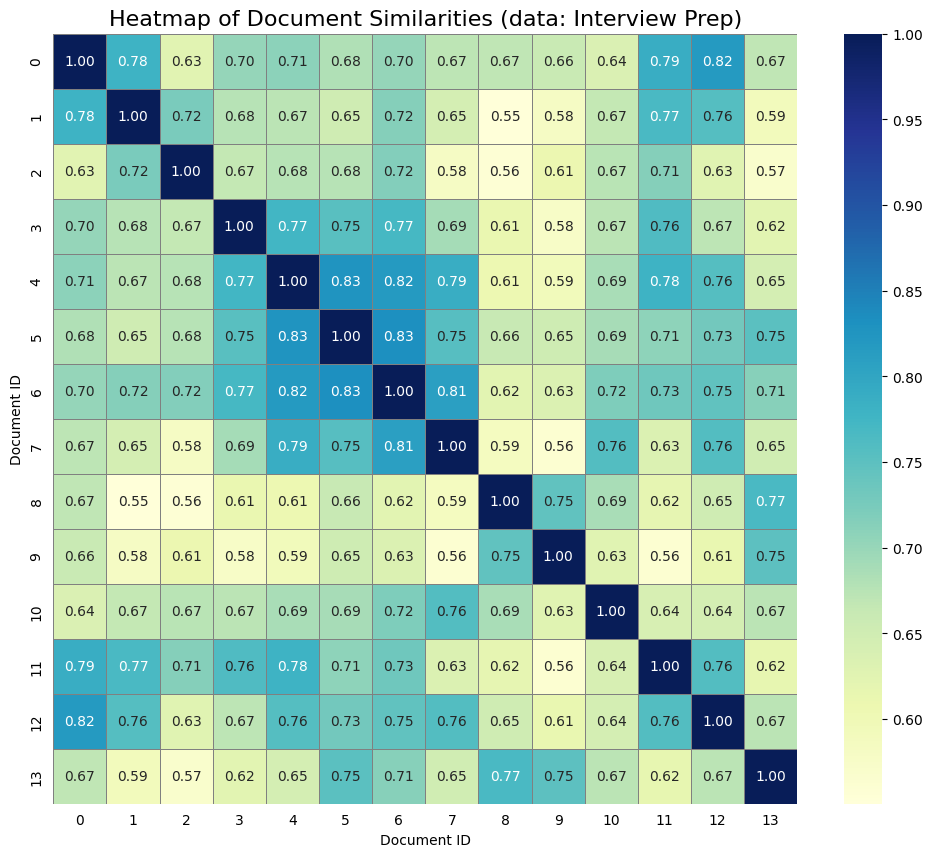

In [46]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the tensor to a numpy array
tensor_np = similarity_scores.numpy()

# Create a heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(tensor_np, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True, linewidths=.5, linecolor='gray')

# Add labels and title
plt.xlabel("Document ID")
plt.ylabel("Document ID")
plt.title("Heatmap of Document Similarities (data: Interview Prep)", fontsize=16)

# Remove axis ticks for a cleaner look
plt.tick_params(left=False, bottom=False)

# Display the heatmap
plt.show()


In [4]:
model_id = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer, model = emb.initialize_sentence_transformer_model(model_id)
embeddings = emb.batch_embeddings(data["text"], tokenizer, model) # pyright: ignore
similarity_scores = ss.batch_similarity_scores(embeddings, metric="cosine")

/Users/erikluu/Documents/Poly/Thesis/LociNet/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Similarity batch: 0/14: 100%|██████████| 1/1 [00:00<00:00, 352.26it/s]


### Pipeline 1
- similarity metric: cosine
- edge constructor: knn (k=2)
- aggregator: mean pooling
- clusterer: None
- small world: None

In [5]:
# make graph
pickle_name = "graphs/interview_all-MiniLM-L6-v2_cosine_knn2_mean_x_x.pickle"
knn_edge_constructor = lambda sim_mat, ids: edge.knn(sim_mat, ids, k=2)
G = pipe.connect_directly(embeddings, similarity_scores, data["ids"],
                          similarity_metric="cosine",
                          edge_constructor_f=knn_edge_constructor,
                          aggregator_f=agg.mean_pooling,
                          titles=data["titles"], tags=data["tags"])
utils.save_graph_to_pickle(G, pickle_name)

Similarity batch: 0/14: 100%|██████████| 1/1 [00:00<00:00, 432.89it/s]


In [6]:
# turn to json
encoding_f = lambda x: utils.pca(x, n_components=5)
utils.pickle_to_json(pickle_name, encoding_f)

### Pipeline 2
- similarity metric: cosine
- edge constructor: knn (k=2)
- aggregator: mean pooling
- clusterer: None
- small world: Watts-Strogatz (p=.2)

In [7]:
# make graph
pickle_name = "graphs/interview_all-MiniLM-L6-v2_cosine_knn2_mean_x_watts.pickle"
knn_edge_constructor = lambda sim_mat, ids: edge.knn(sim_mat, ids, k=2)
G = pipe.connect_directly(embeddings, similarity_scores, data["ids"],
                          similarity_metric="cosine",
                          edge_constructor_f=knn_edge_constructor,
                          aggregator_f=agg.mean_pooling,
                          titles=data["titles"], tags=data["tags"])
G = gc.watts_strogatz(G, similarity_scores, p=0.2, seed=42)
utils.save_graph_to_pickle(G, pickle_name)

Similarity batch: 0/14: 100%|██████████| 1/1 [00:00<00:00, 476.19it/s]
Watts-Strogatz: : 14it [00:00, 1221.99it/s]


In [8]:
encoding_f = lambda x: utils.pca(x, n_components=5)
utils.pickle_to_json(pickle_name, encoding_f)

### Pipeline 3
- similarity metric: cosine
- edge constructor: knn (k=2)
- aggregator: mean pooling
- clusterer: kmeans (n=2)
- small world: None

In [9]:
pickle_name = "graphs/interview_all-MiniLM-L6-v2_cosine_knn2_mean_kmeans2_x.pickle"
knn_edge_constructor = lambda sim_mat, ids: edge.knn(sim_mat, ids, k=2)
kmeans_clusterer = lambda embeddings: cluster.kmeans(embeddings, n_clusters=2)
G = pipe.cluster_and_connect(embeddings, similarity_scores, data["ids"],
                             similarity_metric="cosine",
                             edge_constructor_f=knn_edge_constructor,
                             clusterer_f=kmeans_clusterer,
                             aggregator_f=agg.mean_pooling,
                             titles=data["titles"], tags=data["tags"])
utils.save_graph_to_pickle(G, pickle_name)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Similarity batch: 0/3: 100%|██████████| 1/1 [00:00<00:00, 311.45it/s]


In [10]:
encoding_f = lambda x: utils.pca(x, n_components=5)
utils.pickle_to_json(pickle_name, encoding_f)

# Data: medium_1k_tags.csv

Medium Articles: [huggingface dataset](https://huggingface.co/datasets/fabiochiu/medium-articles)
- Blog post's tags must appear >1k times.

In [11]:
data = load_data("data/medium_1k_tags_simplified.csv", n=100)

## Embeddings: sentence-transformers/all-MiniLM-L6-v2
Metric: Cosine Similarity

In [12]:
model_id = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer, model = emb.initialize_embedding_model(model_id)
embeddings = emb.batch_embeddings(data["text"], tokenizer, model) # pyright: ignore
similarity_scores = ss.batch_similarity_scores(embeddings, metric="cosine")

/Users/erikluu/Documents/Poly/Thesis/LociNet/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Similarity batch: 96/100: 100%|██████████| 4/4 [00:00<00:00, 76.28it/s]


### Pipeline 4
- similarity metric: cosine
- edge constructor: knn (k=3)
- aggregator: mean pooling
- clusterer: None
- small world: None

In [13]:
pickle_name = "graphs/medium1k_all-MiniLM-L6-v2_cosine_knn3_mean_x_x.pickle"
knn_edge_constructor = lambda sim_mat, ids: edge.knn(sim_mat, ids, k=3)
G = pipe.connect_directly(embeddings, similarity_scores, data["ids"],
                          similarity_metric="cosine",
                          edge_constructor_f=knn_edge_constructor,
                          aggregator_f=agg.mean_pooling,
                          titles=data["titles"], tags=data["tags"], simplified_tags=data["simplified_tags"])
utils.save_graph_to_pickle(G, pickle_name)

Similarity batch: 96/100: 100%|██████████| 4/4 [00:00<00:00, 210.39it/s]


In [14]:
import src.utils as utils
import src.metrics as m
G = utils.load_graph_from_pickle("graphs/medium1k_all-MiniLM-L6-v2_cosine_knn3_mean_x_x.pickle")

In [15]:
m.aggregate_metrics(G, sample_size=10, depth=2, n_tags=1)

Mental Note Vol. 24
Your Brain On Coronavirus
Mind Your Nose
The 4 Purposes of Dreams
Surviving a Rod Through the Head
Mentally, Young Adults Are Suffering Most From COVID
How to Turn Your Popular Blog Series Into a Bestselling Book
Dr Faisal Dar — Pioneer of Liver Transplantation in Pakistan
Sunlight — The Natural Supplement For Our Mental Health
Occam’s dice
To Quickly Build Trust, Tell Your Origin Story
Four Exercises to Strengthen Your Writing
Facing Three Fundamental Coronavirus Fears
For Creatives, Silence Isn’t Always Golden
This 10-Minute Routine Will Increase Your Clarity And Creativity
The Ted Talk That Changed My Life
How to Make Your Day Job Support Your Art
Exploring New York City Restaurants
A Social Worker Offered Mormon Lingo to Me When I Was in Crisis, Told Me to Think Happy Thoughts, and Hung Up on Me — While I Was Still in Crisis
An Effective Five-Step Process for Writing Captivating Headlines
Loss Aversion — how fear influences customer choice
The FDA Banned These C

TypeError: '<=' not supported between instances of 'str' and 'int'

In [42]:
encoding_f = lambda x: utils.pca(x, n_components=5)
utils.pickle_to_json(pickle_name, encoding_f)

### Pipeline 5
- similarity metric: cosine
- edge constructor: knn (k=3)
- aggregator: mean pooling
- clusterer: kmeans (n=5)
- small world: None

In [35]:
pickle_name = "graphs/medium1k_all-MiniLM-L6-v2_cosine_knn3_mean_kmeans5_x.pickle"
knn_edge_constructor = lambda sim_mat, ids: edge.knn(sim_mat, ids, k=3)
kmeans_clusterer = lambda embeddings: cluster.kmeans(embeddings, n_clusters=5)
G = pipe.cluster_and_connect(embeddings, similarity_scores, data["ids"],
                             similarity_metric="cosine",
                             edge_constructor_f=knn_edge_constructor,
                             clusterer_f=kmeans_clusterer,
                             aggregator_f=agg.mean_pooling,
                             titles=data["titles"], tags=data["tags"], simplified_tags=data["simplified_tags"])
utils.save_graph_to_pickle(G, pickle_name)

Similarity batch: 0/6: 100%|██████████| 1/1 [00:00<00:00, 512.56it/s]


In [36]:
encoding_f = lambda x: utils.pca(x, n_components=5)
utils.pickle_to_json(pickle_name, encoding_f)

### Pipeline 6
- similarity metric: cosine
- edge constructor: knn (k=3)
- aggregator: mean pooling
- clusterer: kmeans (n=20)
- small world: None

What happens when we use the same number of clusters as there are unique tags? Greater than? Less than?

In [37]:
pickle_name = "graphs/medium1k_all-MiniLM-L6-v2_cosine_knn3_mean_kmeans20_x.pickle"
knn_edge_constructor = lambda sim_mat, ids: edge.knn(sim_mat, ids, k=3)
kmeans_clusterer = lambda embeddings: cluster.kmeans(embeddings, n_clusters=20)
G = pipe.cluster_and_connect(embeddings, similarity_scores, data["ids"],
                             similarity_metric="cosine",
                             edge_constructor_f=knn_edge_constructor,
                             clusterer_f=kmeans_clusterer,
                             aggregator_f=agg.mean_pooling,
                             titles=data["titles"], tags=data["tags"], simplified_tags=data["simplified_tags"])
utils.save_graph_to_pickle(G, pickle_name)

Similarity batch: 0/1:   0%|          | 0/1 [00:00<?, ?it/s]

Similarity batch: 0/21: 100%|██████████| 1/1 [00:00<00:00, 441.32it/s]


In [38]:
encoding_f = lambda x: utils.pca(x, n_components=5)
utils.pickle_to_json(pickle_name, encoding_f)

### Pipeline 7
- similarity metric: cosine
- edge constructor: knn (k=3)
- aggregator: mean pooling
- clusterer: kmeans (n=5)
- small world: Watts Strogatz (p=0.2)

What happens when we use the same number of clusters as there are unique tags? Greater than? Less than?

In [39]:
pickle_name = "graphs/medium1k_all-MiniLM-L6-v2_cosine_knn3_mean_kmeans5_watts20.pickle"
knn_edge_constructor = lambda sim_mat, ids: edge.knn(sim_mat, ids, k=3)
kmeans_clusterer = lambda embeddings: cluster.kmeans(embeddings, n_clusters=5)
G = pipe.cluster_and_connect(embeddings, similarity_scores, data["ids"],
                             similarity_metric="cosine",
                             edge_constructor_f=knn_edge_constructor,
                             clusterer_f=kmeans_clusterer,
                             aggregator_f=agg.mean_pooling,
                             titles=data["titles"], tags=data["tags"], simplified_tags=data["simplified_tags"])
G = gc.watts_strogatz(G, similarity_scores, p=0.2, seed=42)
utils.save_graph_to_pickle(G, pickle_name)

Similarity batch: 0/30:   0%|          | 0/1 [00:00<?, ?it/s]

Similarity batch: 0/6: 100%|██████████| 1/1 [00:00<00:00, 411.00it/s]
Watts-Strogatz: : 100it [00:00, 1634.01it/s]


In [40]:
encoding_f = lambda x: utils.pca(x, n_components=5)
utils.pickle_to_json(pickle_name, encoding_f)

# Data: Medium 1k (n=200)

In [13]:
df = pd.read_csv("data/medium1k.csv")

In [27]:
text = df[df["title"] == "Exploring New York City Restaurants"]["text"].values[0]

with open("output.txt", "w") as file:
    file.write(text)

In [7]:
data = load_data("data/medium1k.csv", n=100)
ids = data["ids"]

In [8]:
embeddings = utils.load_from_pickle("embeddings/medium1k_minilm_mean_n10000.pickle")[:100]
similarity_scores = ss.batch_similarity_scores(embeddings, metric="cosine")

In [9]:
pickle_name = "graphs/medium1k_mpnet_cosine_knn3_mean_kmeans100_x_lmao_100.pickle"
knn_edge_constructor = lambda sim_mat, ids: edge.knn(sim_mat, ids, k=3)
kmeans_clusterer = lambda embeddings: cluster.kmeans(embeddings, n_clusters=10)
G = pipe.cluster_and_connect(embeddings, similarity_scores, data["ids"],
                             similarity_metric="cosine",
                             edge_constructor_f=knn_edge_constructor,
                             clusterer_f=kmeans_clusterer,
                             aggregator_f=agg.mean_pooling,
                             titles=data["titles"], tags=data["tags"], simplified_tags=data["simplified_tags"])
utils.save_graph_to_pickle(G, pickle_name)

In [10]:
encoding_f = lambda x: utils.pca(x, n_components=5)
utils.pickle_to_json(pickle_name, encoding_f)